In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
import igraph as ig
import numpy as np

# ============================================================
# Repeat relevant operations
# ============================================================

# Build the small graph used to explain concepts
eoh = 4
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                          min_units=1, max_units=10, eoh=eoh, seed=42)
tug = util.build_time_unfolded_graph(g, eoh=eoh)
node_counts, arc_counts = util.get_counts(tug, flows, paths)

# Constraints for Regularization

Where there's room for one elephant, there's room for two

## Something Fishy is Going On

**Notice how we are consistently getting 0 RSSE?**

In [2]:
rflows, rpaths = util.solve_path_selection_full(tug, node_counts, arc_counts, verbose=0, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows, rpaths, sort='descending')
sse = util.get_reconstruction_error(tug, rflows, rpaths, node_counts, arc_counts)
print(f'\nRSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
8.17: 2,3 > 3,3
5.47: 0,2 > 1,2 > 2,2 > 3,2
3.74: 3,3
3.10: 0,1 > 1,1 > 2,0 > 3,0
1.79: 1,0 > 2,0 > 3,0
1.79: 0,1 > 1,1 > 2,0 > 3,2
1.53: 1,0 > 2,0 > 3,2

RSSE: 0.00


> **How can that be the case?**

## The Must be Some Noise in Your Dataset

**So far, we have implicitly assumed _noiseless data_**

We will fix that by adding some _proportional noise_

* Which we picked since it is reasonably realistic
* ...Even if it causes issues for our MSE loss

**This is done in the `add_proportional_noise` function:**

```python
# Add noise to the node counts
for k, v in node_counts.items():
    node_counts[k] = max(0, v * (1 + np.random.normal(0, sigma)))
# Add noise to the arc counts
for k, v in arc_counts.items():
    arc_counts[k] = max(0, v * (1 + np.random.normal(0, sigma)))
```

* The `sigma` parameter controls the noise level


## There Must be Some Noise in Your Dataset

**Let's inject _a lot_ of noise and inspect the results**

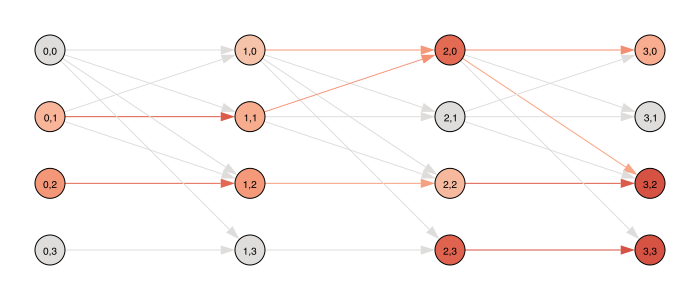

In [3]:
node_counts_n, arc_counts_n = util.add_proportional_noise(node_counts, arc_counts, sigma=0.2, seed=42)
visual_style = util.get_visual_style(tug, vertex_weights=node_counts_n, edge_weights=arc_counts_n)
ig.plot(tug, **visual_style, bbox=(700, 300), margin=50)

## Solving the Noisy Path Formulation

**Let's try to solve the path formulation with noisy data**

In [4]:
rflows_n, rpaths_n = util.solve_path_selection_full(tug, node_counts_n, arc_counts_n, verbose=0, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows_n, rpaths_n, sort='descending', max_paths=15)
sse = util.get_reconstruction_error(tug, rflows_n, rpaths_n, node_counts_n, arc_counts_n)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
7.28: 2,3 > 3,3
4.49: 3,3
3.02: 0,2 > 1,2 > 2,2 > 3,2
2.22: 0,1 > 1,1 > 2,0 > 3,0
2.19: 0,2 > 1,2
2.08: 3,2
1.48: 1,0 > 2,0 > 3,2
1.47: 1,0 > 2,0 > 3,0
1.43: 2,3
1.28: 2,2 > 3,2
1.27: 0,1 > 1,1 > 2,0 > 3,2
0.90: 0,1 > 1,1
0.84: 0,2
0.60: 3,0
0.45: 1,0 > 2,0
...
RSSE: 1.64


## Solving the Noisy Path Formulation

**There some very noticeable differences w.r.t. the baseline**

* The RSSE is a bit higher, which could be expected
* But there are also _many more_ paths, and they tend to be _shorter_

> **What is going on?**

**We have overfitting issues**

* Our data-mining model is _almost free of bias_ (we can use any possible path)
* Hence, the model tries to cover all nodes with many, short, paths

> **Can we do something about it?**

## L1 Regularization, Put to Its Purpose

**We know that we can use an L1 regularizer to encourage longer paths**

...After all, L1 and L2 regularization were born to _counter overfitting_

In [5]:
rflows_n2, rpaths_n2 = util.solve_path_selection_full(tug, node_counts_n, arc_counts_n, alpha=3, verbose=0, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows_n2, rpaths_n2, sort='descending')
sse = util.get_reconstruction_error(tug, rflows_n2, rpaths_n2, node_counts_n, arc_counts_n)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
7.92: 2,3 > 3,3
4.80: 0,2 > 1,2 > 2,2 > 3,2
2.04: 0,1 > 1,1 > 2,0 > 3,0
1.87: 0,1 > 1,1 > 2,0 > 3,2
1.35: 1,0 > 2,0 > 3,2
1.35: 1,0 > 2,0 > 3,0
0.55: 0,1 > 1,1 > 2,0 > 3,3
0.46: 1,0 > 2,0 > 3,3
RSSE: 4.96


We get _fewer, longer_ paths, at the expense of a _higher RSSE_

## L1 Regularization, Put to Its Purpose

**As usual, we can try to improve our results via consolidation**

In [6]:
node_counts_r, arc_counts_r = util.get_counts(tug, rflows_n2, rpaths_n2)
cflows, cpaths, cflag = util.consolidate_paths(tug, rpaths_n2, node_counts_r, arc_counts_r)
print('FLOW: PATH')
util.print_solution(tug, cflows, cpaths, sort='descending', max_paths=5)

FLOW: PATH
7.92: 2,3 > 3,3
4.80: 0,2 > 1,2 > 2,2 > 3,2
3.39: 0,1 > 1,1 > 2,0 > 3,0
2.16: 1,0 > 2,0 > 3,2
1.07: 0,1 > 1,1 > 2,0 > 3,2
...


In [7]:
util.print_ground_truth(flows, paths, sort='descending')

8.17: 2,3 > 3,3
5.47: 0,2 > 1,2 > 2,2 > 3,2
4.89: 0,1 > 1,1 > 2,0 > 3,0
3.74: 3,3
3.32: 1,0 > 2,0 > 3,2


* We got many of the ground truth paths correctly, but we are still using many spurious ones

## Minimum Cover Constraints

**Perhaps we could try to counter the adverse effects of the L1 term**

...Without loosing all of its benefits

* If the L1 weight is too low, the regularizer has little effect
* ...But if it is too high, the solver stops focusing on the count reconstruction

> **What can we do?**

**One way to achieve this consists in introducing _new constraints_**

* For example, we could require for each vertex
* ...To recover a _minimum fraction_ $\gamma$ of the total count, i.e.

$$
Vx \geq \gamma v
$$

## Minimum Cover Constraints

**The path formulation then becomes**

$$
\arg \min_{x} \left\{\frac{1}{2} x^T P x + q^T x \mid Vx \geq \gamma v, x \geq 0 \right\}
$$

With $P = V^T V + E^T E$ and $q = -V^T v -E^T \hat{e} + \alpha$

* We have incorporated both the L1 term (them $\alpha$ term)
* ...And the minimum cover constraints

**When calling the OSQP solver**

* We need to include $\alpha$ in the definition of $q$
* Then we need to extend the constraint matrix/vectors $A, l, u$
* ...So as to account for $V x \geq \gamma v$

## Solving the Modified Path Formulation

Let's try to solve the problem for $\alpha = 3$ and $\gamma = 0.8$

In [8]:
rflows_n3, rpaths_n3 = util.solve_path_selection_full(tug, node_counts_n, arc_counts_n, alpha=3, verbose=0,
                                                    min_vertex_cover=0.95, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows_n3, rpaths_n3, sort='descending', max_paths=10)
sse = util.get_reconstruction_error(tug, rflows_n3, rpaths_n3, node_counts_n, arc_counts_n)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
8.28: 2,3 > 3,3
5.23: 0,2 > 1,2 > 2,2 > 3,2
2.62: 3,3
2.42: 0,1 > 1,1 > 2,0 > 3,0
1.87: 0,1 > 1,1 > 2,0 > 3,2
1.78: 1,0 > 2,0 > 3,0
1.52: 1,0 > 2,0 > 3,2
0.63: 3,2
0.41: 0,2 > 1,2
0.14: 0,1 > 1,1 > 2,0 > 3,3
...
RSSE: 3.13


/Users/michelelombardi/Library/Caches/pypoetry/virtualenvs/mining-with-co-eC0Z9-8k-py3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


The RSSE is a bit better

## Solving the Modified Path Formulation

**Let's see what happens with consolidation** 

In [9]:
node_counts_r, arc_counts_r = util.get_counts(tug, rflows_n3, rpaths_n3)
cflows, cpaths, cflag = util.consolidate_paths(tug, rpaths_n3, node_counts_r, arc_counts_r)
print('FLOW: PATH')
util.print_solution(tug, cflows, cpaths, sort='descending', max_paths=5)

FLOW: PATH
8.28: 2,3 > 3,3
5.23: 0,2 > 1,2 > 2,2 > 3,2
4.28: 0,1 > 1,1 > 2,0 > 3,0
3.40: 1,0 > 2,0 > 3,2
2.62: 3,3
...


In [10]:
util.print_ground_truth(flows, paths, sort='descending')

8.17: 2,3 > 3,3
5.47: 0,2 > 1,2 > 2,2 > 3,2
4.89: 0,1 > 1,1 > 2,0 > 3,0
3.74: 3,3
3.32: 1,0 > 2,0 > 3,2


We got all paths right, and the flows are _closer_ to their real value

# Column Generation with Constraints in the Master

Where we make our first acquaintance with the KKT conditions

## CG and Modified Path Formulation

**The new formulation requires to add new constraints _in the master_**

This is is a problem for Column Generation. Due to the constraints:

* Just looking at the gradient may now be misleading
* ...Since changing a variable may _force to change others_

$$
\arg \min_{x} \left\{\frac{1}{2} x^T P x + q^T x \mid V x \geq \gamma v, x \geq 0 \right\}
$$

**We need a "constraint-aware gradient"**

One way to achieve that is to rely on a _Lagrangian approach_

* The idea is to turn the constraints in to _cost terms_
* ...And control their satisfaction by _adjusting weights (multipliers)_

We will discuss this approach in a general setting

## Lagrangian Approach

**Let's consider an optimization in the form**

$$
\text{argmin}_x \left\{ f(x) \mid g(x) \leq 0 \right\} \quad\quad \mathbf{(P1)}
$$

where $x$ belongs to $\mathbb{R}^n$ (i.e. this is numeric optimization)

**From this, we can obtain a related, unconstrained optimization problem**

...By moving the constraints in to the cost function, with _weights/multipliers $\lambda$_:

$$
\text{argmin}_x \mathcal{L}(x, \lambda) = f(x) + \lambda^T g(x)  \quad\quad \mathbf{(P2)}
$$

The term $\mathcal{L}(x, \lambda)$ is called a _Lagrangian_

* If a constraint $g_i(x)$ is violated, $\mathcal{L}$ gets a penalty w.r.t. $f(x)$
* If a constraint $g_i(x)$ is satisfied, $\mathcal{L}$ gets a reward w.r.t. $f(x)$

**We want to solve (P1) by controlling the multipliers in (P2)** 

## ...And KKT Conditions

**Let's assume that $x$ is an _local_ optimum for the original problem**

...If we want to reach it via (P2), the multipliers should be _just right_:

* They should make the Lagrangian gradient null, i.e.
$$
\nabla_x \mathcal{L}(x, \lambda) = 0
$$
* They should be non-negative (or a penalty may turn into a reward):
$$
\lambda \geq 0
$$
* They should be 0 for all satisfied constraints (or $\mathcal{L}$ would be "inflated")
$$
\lambda \odot g(x) = 0
$$
Additionally, $x$ should be feasible, i.e. $g(x) \leq 0$

## ...And KKT Conditions

**If certain [constraint qualifications](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions#Regularity_conditions_(or_constraint_qualifications)) apply, these are _necessary conditions_**

If a point $x$ is a local optimum, then we have:
$$\begin{align}
\nabla_x \mathcal{L}(x, \lambda) & = 0 & \text{(null gradient)}\\
\lambda & \geq 0  & \text{(dual feasibility)} \\
\lambda \odot g(x) & = 0  & \text{(complementary slackness)}\\
g(x) & \leq 0  & \text{(primal feasibility)}
\end{align}$$

They are known as [Karush-Kuhn-Tucker (KKT) first order optimality conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions)

**Some comments:**

* If $f(x)$ and $g(x)$ are convex, the KKT conditions _are also sufficient_
* Equality constrains are equivalent to $g(x) \leq 0$ and $-g(x) \leq 0$
* ...Which can be manipulated to obtain (slighly) simpler formulas

## How to Use the KKT Conditions

**We can use the KKT conditions to _constrain_ $x$ to be an optimum**

* This is useful in bi-level optimization, i.e.:

$$
\text{argmax}_y \left\{ f(z) \mid z = \text{argmin}_{x \in X} \ g(x, y) \right\}
$$

* If $X$ and $g$ are convex, we can use the KKT conditions are constraints
* ...And replace the optimization step $\text{argmin}_{x \in X} \ g(x, y)$
* Typically, this is useful only the conditions reduce to a simple form

**We can use the KKT conditions to _check_ whether $x$ is a local optimum**

...Assuming we are in convex optimization and constraint qualifications are met

* If we fix $x$, then the KKT conditions reduce to a linear system
* ...If we can solve it, then $x$ is a local optimum
* ...And we have found the corresponding optimal multipliers

## How to Use the KKT Conditions in CG

As a by-product of the previous use case...

**If we know that $x$ is an optimum, we can _obtain_ the optimal $\lambda$**

This is the application we care about

* If we have _constraints in the master_ problem
* ...Rather than searching for variables such that:

$$
\frac{\partial}{\partial x_j} f(x) < 0
$$

* ...We search instead for _variables such that_:

$$
\frac{\partial}{\partial x_j} \mathcal{L}(x, \lambda) < 0
$$




## CG for the Modified Path Formulation

**The modified Path Formulation can be rewritten as:**

$$
\arg \min_{x} \left\{\frac{1}{2} (\|Vx - v\|_2^2 + \|Ex - e\|_2^2) + \alpha x \mid Vx \geq \gamma v, x \geq 0 \right\}
$$

From which we obtain:

$$
\mathcal{L}(x, \lambda, \mu) = \frac{1}{2} (\|Vx - v\|_2^2 + \|Ex - e\|_2^2) + \alpha x + \lambda^T (\gamma v - Vx) - \mu^T x
$$

And finally:

$$
\frac{\partial}{\partial x_j} \mathcal{L}(x, \lambda, \mu) = \sum_{i=1}^{n_v} r^v_i V_{ij} + \sum_{k=1}^{n_e} r^e_k E_{kj} - \sum_{i=1}^{n_v} \lambda_i V_{ij} + \alpha - \mu_j
$$

## CG for the Modified Path Formulation

**Therefore, we can modify our pricing problem so that we minimize:**

$$
\sum_{i=1}^{n_v} (r^v_i - \lambda_i) V_{ij} + \sum_{k=1}^{n_e} r^e_k E_{kj} + \alpha - \mu_j
$$

Whenever we include an _arc_ $k$ in the path we are constructing:

* We accumulate a gradient term equal to $r^e_k$
* ...Exactly the same as before

Whenever we include a _node_ $i$ in the path we are constructing:

* We accumulate a gradient term equal to $r^v_i - \lambda_i$
* I.e. we subtract the multiplier associated to the $i$-th min cover constraint

Then, for every path, we add $\alpha$ and we subtract $\mu_j$

**But how do we get the multipliers?**

## CG for the Modified Path Formulation

**Every $\lambda_i$ is associated _to a (min cover) constraint_:**

...And we have _all of those_ in our problem!

* Hence, we could compute $\lambda$ for the current optimal solution
* In practice, the OSQP sover can _compute $\lambda$ for us_

**Every $\mu_j$ is associated to _$x_j \geq 0$ constraint_:**

...And unfortunately we have those only for the paths in the pool

* However, we know that $\mu_j \geq 0$ (by dual feasibility)
* ...And we would have $\mu_j > 0$ only having $x_j < 0$ was beneficial
* ...But we are looking for paths with exactly the opposite property
* Hence, we can just assume _$\mu_j = 0$_ when generating new paths


# Full CG In Action

This is Column Generation as it was meant to be

## Obtaining the Duals

**We start by solving again the master problem**

...But this time we retrieve the optimal (dual) multipliers

* They are the same weights $\lambda$ used in the ADMM
* ...And can be obtain from the OSQP solution object

In [11]:
mvc, alpha = 0.95, 1
rflows_n3, rpaths_n3, nneg_duals3, mvc_duals3 = util.solve_path_selection_full(tug, node_counts_n, arc_counts_n,
                                                    alpha=alpha, verbose=0, min_vertex_cover=0.95, return_duals=True, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows_n3, rpaths_n3, sort='descending', max_paths=6)
sse = util.get_reconstruction_error(tug, rflows_n3, rpaths_n3, node_counts_n, arc_counts_n)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
8.28: 2,3 > 3,3
4.36: 0,2 > 1,2 > 2,2 > 3,2
2.62: 3,3
2.45: 0,1 > 1,1 > 2,0 > 3,0
1.68: 1,0 > 2,0 > 3,0
1.68: 0,1 > 1,1 > 2,0 > 3,2
...
RSSE: 2.54


## Inspecting the Duals

**Let's inspect the multipliers for the minimum cover constraints**

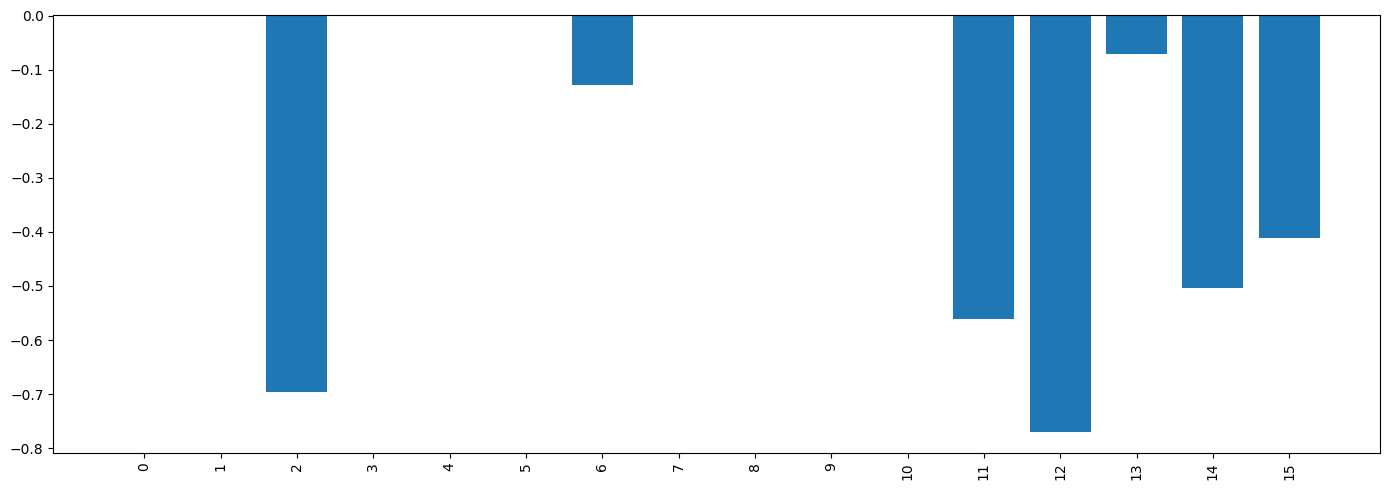

In [12]:
util.plot_dict({i:v for i, v in enumerate(mvc_duals3)}, figsize=figsize)

* Some values are 0 (when the constraint is satisfied with a slack)
* ...And some (unexpectedly, are _negative_)

## Inspecting the Duals

**Let's inspect the multipliers for the minimum cover constraints**

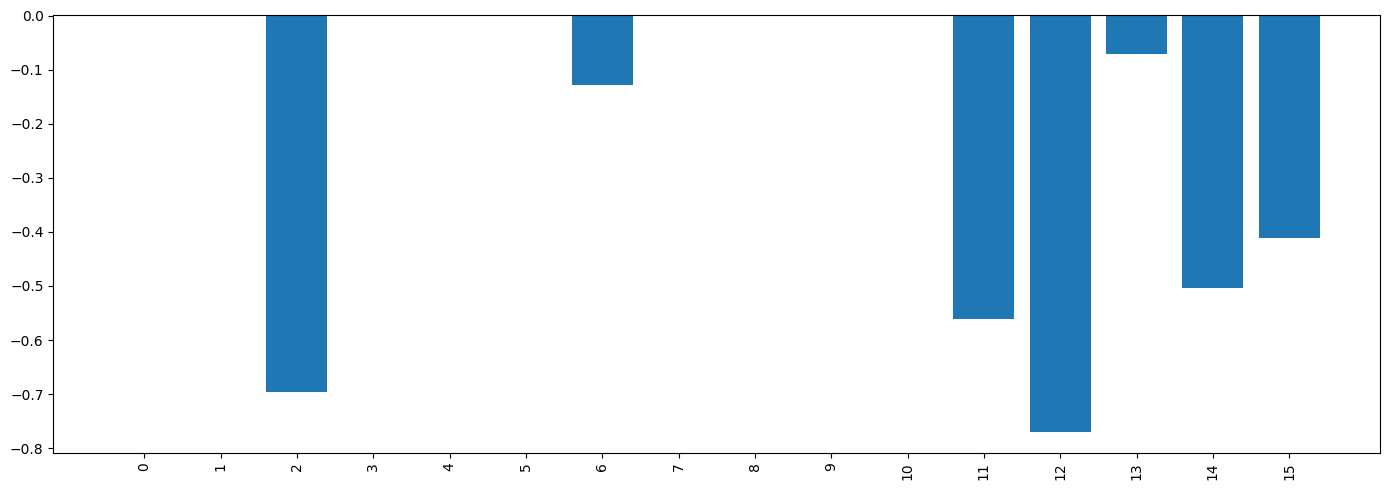

In [13]:
util.plot_dict({i:v for i, v in enumerate(mvc_duals3)}, figsize=figsize)

* The reason is the constraint direction: we have $Vx \geq \gamma \hat{v}$ and not $-Vx \leq - \gamma \hat{v}$
* We could fix by switching the constraint direction...

## Inspecting the Duals

**Let's inspect the multipliers for the minimum cover constraints**

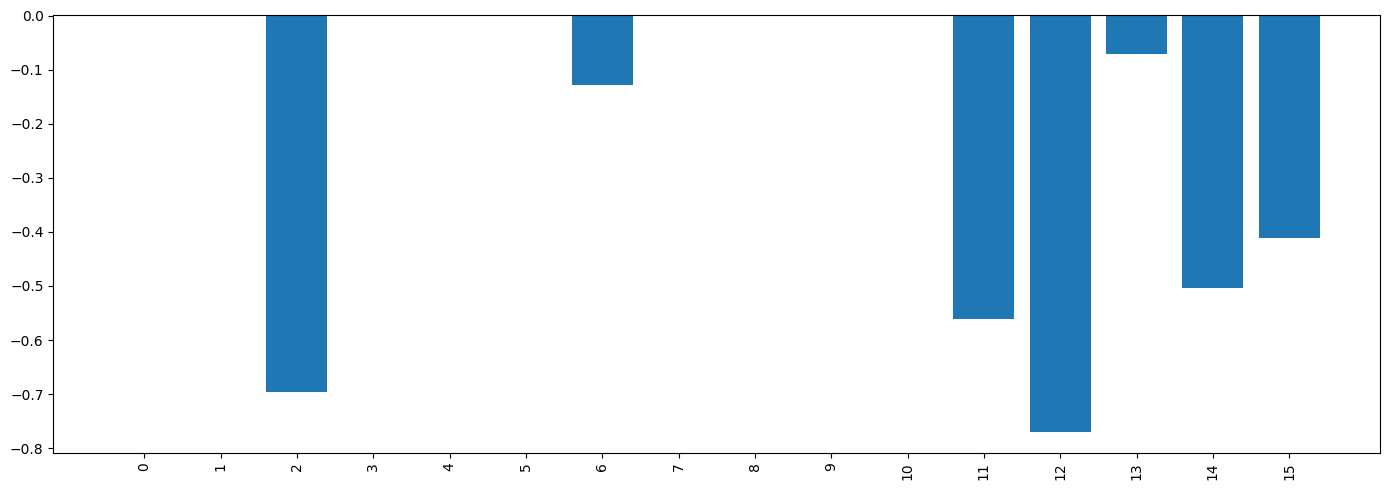

In [14]:
util.plot_dict({i:v for i, v in enumerate(mvc_duals3)}, figsize=figsize)

* ...Or by reworking the change though the KKT formulas
* In our case, when we include a node we _add $\lambda_i$ instead of subtracting it_

## Checking the Pricing Solution

**Our pricing problem code can handle both the duals and the L1 weight**

We modify node residuals by adding the cover multipliers:

```python
if cover_duals is not None:
    for i, v in enumerate(tug.vs):
        nk = v['time'], v['index_o']
        nres[nk] += cover_duals[i]
```

* This provides an _incentive_ to select paths
* ...That traverse a node whose cover constraint is satisfied with a slack

And we add the constant $\alpha$ to the final path weights:

```python
    spw = [v + alpha for v in spw]

```

* This a uniform _disincentive_ so select paths

**The shortest paths problem is solved as usual**

## Running the CG Approach

**We can now run the CG approach**

In [15]:
rflows_cg, rpaths_cg = util.trajectory_extraction_cg(tug, node_counts_n, arc_counts_n,
                                    alpha=alpha, min_vertex_cover=mvc, max_iter=30,
                                    verbose=1, max_paths_per_iter=10, solver='piqp')
sse = util.get_reconstruction_error(tug, rflows_cg, rpaths_cg, node_counts_n, arc_counts_n)
print(f'RSSE: {np.sqrt(sse):.2f}')

It.0, sse: 209.13, #paths: 26, new: 10
It.1, sse: 83.13, #paths: 34, new: 8
It.2, sse: 67.39, #paths: 41, new: 7
It.3, sse: 42.31, #paths: 45, new: 4
It.4, sse: 7.24, #paths: 47, new: 2
It.5, sse: 6.46, #paths: 49, new: 2
It.6, sse: 6.46, #paths: 49, new: 0
RSSE: 2.54


/Users/michelelombardi/Library/Caches/pypoetry/virtualenvs/mining-with-co-eC0Z9-8k-py3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


* Indeed,  we obtain the same RSSE as the approach using all paths

**We now know how to use CG with constraints in the master problem**

...Which significantly extends the applicability of the method

## Some References

CG is main studied in the context of Linear Optimization

* ["Column Generation"](https://www.or.rwth-aachen.de/files/research/publications/colgen.pdf), by Lübbecke
* ["Column Generation"](https://books.google.it/books?hl=en&lr=&id=8-5fCG2lumcC&oi=fnd&pg=PR5&dq=column+generation&ots=BYqP5ZI6Ki&sig=rV6e53xhZUY9YrKAqP7DcvoNXE4&redir_esc=y#v=onepage&q=column%20generation&f=false), by Desaulniers, Desrosiers, and Solomon 